# Projeto de Engenharia do Conhecimento 2023/2024

*Projeto by: Renato Ferreira (58238), Pedro Lopes(58196), Simão Quintas (58190)*

## Imports

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

Let's drop the rows and columns with a large number of NA values

In [2]:
data = pd.read_csv('proj-data.csv', na_values='?')

# Remover as colunas que indicam se algo foi medido ou não, a coluna com a indentificação e colunas com muitos valores ausentes
data.drop(data.filter(like='measured').columns, axis=1, inplace=True)
data.drop('[record identification]', axis=1, inplace=True)

hyperthyroid_conditions = ['A', 'B', 'C', 'D']
hypothyroid_conditions = ['E', 'F', 'G', 'H']
binding_protein = ['I', 'J']
general_health = ['K']
replacement_therapy = ['L', 'M', 'N']
discordant = ['R']
none = ['-']

for i in range(len(data)):
    if data.at[i, "diagnoses"] in hyperthyroid_conditions :
        data.at[i, "diagnoses"] = 1
    elif data.at[i, "diagnoses"] in hypothyroid_conditions :
        data.at[i, "diagnoses"] = 2
    elif data.at[i, "diagnoses"] in binding_protein :
        data.at[i, "diagnoses"] = 3
    elif data.at[i, "diagnoses"] in general_health :
        data.at[i, "diagnoses"] = 4
    elif data.at[i, "diagnoses"] in replacement_therapy :
        data.at[i, "diagnoses"] = 5
    elif data.at[i, "diagnoses"] in discordant :
        data.at[i, "diagnoses"] = 6
    elif data.at[i, "diagnoses"] in none :
        data.at[i, "diagnoses"] = 7 
    else:
        data.at[i, "diagnoses"] = 8 

data.replace('f', 0, inplace=True)
data.replace('t', 1, inplace=True)
data.replace('F', 0, inplace=True)
data.replace('M', 1, inplace=True)

data

,age:,sex:,on thyroxine:,query on thyroxine:,on antithyroid medication:,sick:,pregnant:,thyroid surgery:,I131 treatment:,query hypothyroid:,...,hypopituitary:,psych:,TSH:,T3:,TT4:,T4U:,FTI:,TBG:,referral source:,diagnoses
0,29,0.0,0,0,0,0,0,0,0,1,...,0,0,0.3,NaN,NaN,NaN,NaN,NaN,other,7
1,29,0.0,0,0,0,0,0,0,0,0,...,0,0,1.6,1.9,128.0,NaN,NaN,NaN,other,7
2,36,0.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,26.0,other,7
3,60,0.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,26.0,other,7
4,77,0.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,21.0,other,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7333,56,1.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,64.0,0.83,77.0,NaN,SVI,7
7334,22,1.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,91.0,0.92,99.0,NaN,SVI,7
7335,69,1.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,113.0,1.27,89.0,NaN,SVI,3
7336,47,0.0,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,75.0,0.85,88.0,NaN,other,7


Obter os valores da feature matrix tratados e da target variable, removendo as colunas com poucos valores.

In [7]:
missingValues = {}

for i in data.values:
  c=0
  for j in i:
    if pd.isna(j):
      if data.columns[c] not in missingValues:
        missingValues[data.columns[c]] = 1
      else:
        missingValues[data.columns[c]] += 1
    c+=1

for c in missingValues.keys():
  if missingValues[c] > 0:
    print(c,str(missingValues[c]),"missing values!")

X = data.iloc[:,:-1]

# Remover linhas com poucos valores medidos
X.dropna(axis=1, thresh=5500, inplace=True) # 5500 porque é ~75% do número total
X.drop('TBG:',axis=1,inplace=True) # Tem 7054 missing values
X.drop('T3:',axis=1,inplace=True) # Tem 2068 missing values
X.drop('referral source:',axis=1,inplace=True)

y = data.iloc[: , -1:]
y = y.astype('int')

T3: 2068 missing values!
TT4: 362 missing values!
T4U: 664 missing values!
FTI: 658 missing values!
TBG: 7054 missing values!
TSH: 671 missing values!
sex: 240 missing values!


## Feature Selection

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

#SCALER
scaler = StandardScaler()
scaler.fit(X_train)
Xt_train=scaler.fit_transform(X_train)
Xt_test=scaler.fit_transform(X_test)

#FEATURE SELECTION
N,M = Xt_train.shape

rfr=RandomForestRegressor(random_state=0)
sel = SelectFromModel(estimator=rfr,threshold=0.04)
y_train = y_train.squeeze().ravel()
y_test = y_test.squeeze().ravel()
sel.fit(Xt_train, y_train)

print("Default threshold: ", sel.threshold_)

features=sel.get_support()
Features_selected =np.arange(M)[features]

print("The features selected are columns: ", Features_selected)

nX_train=sel.transform(Xt_train)
nX_test=sel.transform(Xt_test)

score = make_scorer(matthews_corrcoef)

Default threshold:  0.04
The features selected are columns:  [ 0  2 16 17 18 19]


1: Feature 16 (0.293830)
2: Feature 19 (0.188841)
3: Feature 17 (0.161341)
4: Feature 18 (0.132939)
5: Feature 0 (0.100973)
6: Feature 2 (0.048124)
7: Feature 1 (0.014136)
8: Feature 10 (0.009445)
9: Feature 6 (0.009191)
10: Feature 9 (0.006833)
11: Feature 7 (0.006124)
12: Feature 5 (0.005364)
13: Feature 13 (0.005027)
14: Feature 4 (0.004354)
15: Feature 15 (0.003590)
16: Feature 8 (0.003191)
17: Feature 3 (0.003120)
18: Feature 12 (0.001945)
19: Feature 11 (0.001112)
20: Feature 14 (0.000521)


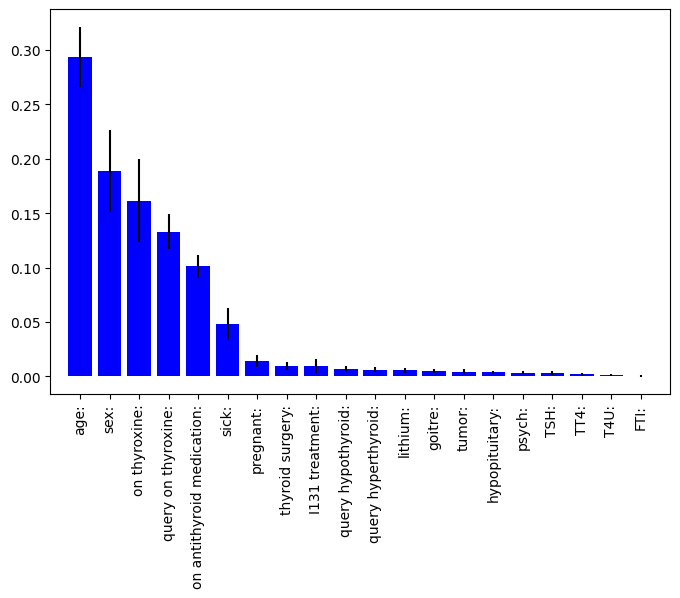

In [9]:
rfc = RandomForestClassifier(random_state=123)      
rfc = rfc.fit(Xt_train,y_train)
std = np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)

rfc2 = RandomForestClassifier(random_state=123)      
rfc2 = rfc2.fit(Xt_train,y_train)
importances = rfc2.feature_importances_
features = np.argsort(importances)[::-1]
 
for f in range(features.size):
    print("%d: Feature %d (%f)" % (f + 1, features[f],  importances[features[f]]))
 
#Plot the feature importances list:
plt.figure(1, figsize=(8,5))
plt.xticks(range(X.shape[1]), X.columns,rotation=90)
plt.bar(range(Xt_train.shape[1]), importances[features],color="b", yerr=std[features])
plt.xlim([-1, Xt_train.shape[1]])
plt.show()

### Choosing the best combinations

In [10]:
def present_statistics(y_test, preds):
    print("Statistics:")
    print("The Precision is: %7.4f" % precision_score(y_test, preds, average='weighted'))
    print("The Accuracy is: %7.4f" % accuracy_score(y_test, preds))
    print("The Recall is: %7.4f" % recall_score(y_test, preds, average='weighted'))
    print("The F1 score is: %7.4f" % f1_score(y_test, preds, average='weighted'))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, preds))
    print("-------------------------------------------------------------")

# Métodos

## Decision Tree

### Testar o modelo Decision Tree Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

print("Com valores Nan:")

# Create and train the DecisionTreeClassifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Make predictions
tree_preds = tree_model.predict(X_test)
present_statistics(y_test, tree_preds)

print("Sem valores Nan:")

# Create an instance of the SimpleImputer class with fill_value='-1'
imputer = SimpleImputer(strategy='constant', fill_value=-1)

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the DecisionTreeClassifier model with the simple imputer
tree_model.fit(X_train_imputed, y_train)

# Make predictions
tree_preds = tree_model.predict(X_test_imputed)
present_statistics(y_test, tree_preds)

print("Usando um scaler:")

# Train the DecisionTreeClassifier model with the simple imputer
tree_model.fit(Xt_train, y_train)

# Make predictions
tree_preds = tree_model.predict(Xt_test)
present_statistics(y_test, tree_preds)

Com valores Nan:
Statistics:
The Precision is:  0.8187
The Accuracy is:  0.8131
The Recall is:  0.8131
The F1 score is:  0.8154
The Matthews correlation coefficient is:  0.5934
-------------------------------------------------------------
Sem valores Nan:
Statistics:
The Precision is:  0.8123
The Accuracy is:  0.8022
The Recall is:  0.8022
The F1 score is:  0.8068
The Matthews correlation coefficient is:  0.5752
-------------------------------------------------------------
Usando um scaler:
Statistics:
The Precision is:  0.7919
The Accuracy is:  0.7030
The Recall is:  0.7030
The F1 score is:  0.7388
The Matthews correlation coefficient is:  0.4611
-------------------------------------------------------------


Os resultados ao utilizar valores Nan são melhores.

In [54]:
y_train_flat = np.ravel(y_train)
y_test_flat = np.ravel(y_test)

## KNeighbors

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

print("Usando um scaler:")

# Replace missing values with -1 in the scaled training and testing data
X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

knn_model.fit(X_train_imputed, y_train_flat)

# Predictions
knn_preds = knn_model.predict(X_test_imputed)
present_statistics(y_test, knn_preds)

print("Sem usar scaler:")

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

knn_model.fit(X_train_imputed, y_train_flat)

# Predictions
knn_preds = knn_model.predict(X_test_imputed)
present_statistics(y_test_flat, knn_preds)

Usando um scaler:
Statistics:
The Precision is:  0.7696
The Accuracy is:  0.7956
The Recall is:  0.7956
The F1 score is:  0.7761
The Matthews correlation coefficient is:  0.5019
-------------------------------------------------------------
Sem usar scaler:
Statistics:
The Precision is:  0.7466
The Accuracy is:  0.7798
The Recall is:  0.7798
The F1 score is:  0.7595
The Matthews correlation coefficient is:  0.4730
-------------------------------------------------------------


É melhor ao usar um scaler

## SVC

In [89]:
from sklearn.svm import SVC
svc_model = SVC()

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

svc_model.fit(X_train_imputed, y_train_flat)

svc_preds = svc_model.predict(X_test_imputed)
print(svc_model,"usando scaler:")
present_statistics(y_test_flat, svc_preds)

SVC() usando scaler:
Statistics:
The Precision is:  0.7321
The Accuracy is:  0.8016
The Recall is:  0.8016
The F1 score is:  0.7487
The Matthews correlation coefficient is:  0.4813
-------------------------------------------------------------


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gaussian Naive Bayes

In [74]:
from sklearn.naive_bayes import GaussianNB
gaus_model = GaussianNB()

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

gaus_model.fit(X_train_imputed, y_train_flat)

gaus_preds = gaus_model.predict(X_test_imputed)
print(gaus_model,"sem scaler:")
present_statistics(y_test_flat, gaus_preds)

GaussianNB() sem scaler:
Statistics:
The Precision is:  0.7531
The Accuracy is:  0.1689
The Recall is:  0.1689
The F1 score is:  0.1155
The Matthews correlation coefficient is:  0.2090
-------------------------------------------------------------


## LogisticRegression

In [80]:
from sklearn.linear_model import LogisticRegression
logr_model = LogisticRegression(max_iter=1000)

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

# Train models
logr_model.fit(X_train_imputed, y_train_flat)

logr_preds = logr_model.predict(X_test_imputed)
print(logr_model,"com scaler:")
present_statistics(y_test_flat, logr_preds)

LogisticRegression(max_iter=1000) com scaler:
Statistics:
The Precision is:  0.7340
The Accuracy is:  0.8060
The Recall is:  0.8060
The F1 score is:  0.7559
The Matthews correlation coefficient is:  0.4975
-------------------------------------------------------------


Os melhores modelos são o Decision Tree, KNeighbors e LogisticRegression

## Model Tuning

### Decision Tree Classifier

In [95]:
param_grid = {
    'max_depth': [5,6,7,8,9,10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [3,4,5],
    'max_features': [None],
    'criterion': ['gini','entropy']
}

tree_model = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='f1_macro')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_tree_model = grid_search.best_estimator_

tree_preds = best_tree_model.predict(X_test)

present_statistics(y_test, tree_preds)

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_tree_model, X_train, y_train, cv=5, scoring='f1_macro')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Score:", cv_scores.std())

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 3}
Statistics:
The Precision is:  0.8381
The Accuracy is:  0.8572
The Recall is:  0.8572
The F1 score is:  0.8406
The Matthews correlation coefficient is:  0.6678
-------------------------------------------------------------
Cross-Validation Scores: [0.59565604 0.58089859 0.55663446 0.64405356 0.58498708]
Mean Cross-Validation Score: 0.5924459448999106
Standard Deviation of Cross-Validation Score: 0.028792671344394262


## KNeighbours

In [96]:
param_grid = {
    'n_neighbors': [3,11,13,15,17],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='f1_weighted')

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

grid_search.fit(X_train_imputed, y_train_flat)

print("Best Parameters:", grid_search.best_params_)

best_knn_model = grid_search.best_estimator_

knn_preds = best_knn_model.predict(X_test_imputed)

present_statistics(y_test_flat, knn_preds)

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_knn_model, X_train_imputed, y_train_flat, cv=5, scoring='f1_macro')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Score:", cv_scores.std())

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Statistics:
The Precision is:  0.7779
The Accuracy is:  0.8005
The Recall is:  0.8005
The F1 score is:  0.7826
The Matthews correlation coefficient is:  0.5120
-------------------------------------------------------------
Cross-Validation Scores: [0.53276753 0.51242214 0.48360205 0.5388716  0.53202343]
Mean Cross-Validation Score: 0.5199373498614224
Standard Deviation of Cross-Validation Score: 0.020228322309889083


## Logistic Regression

In [97]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [100],
    'solver': ['liblinear']
}

logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, cv=5, scoring='f1_weighted')

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

grid_search.fit(X_train_imputed, y_train_flat)

print("Best Parameters:", grid_search.best_params_)

best_logreg_model = grid_search.best_estimator_

logreg_preds = best_logreg_model.predict(X_test_imputed)

present_statistics(y_test_flat, logreg_preds)

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_tree_model, X_train, y_train, cv=5, scoring='f1_macro')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Score:", cv_scores.std())

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Statistics:
The Precision is:  0.6872
The Accuracy is:  0.5629
The Recall is:  0.5629
The F1 score is:  0.5960
The Matthews correlation coefficient is:  0.1859
-------------------------------------------------------------
Cross-Validation Scores: [0.58855809 0.58483791 0.55977466 0.6371247  0.5901645 ]
Mean Cross-Validation Score: 0.5920919724919635
Standard Deviation of Cross-Validation Score: 0.025064635654496376


C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3. Model Tuning

For this example we are going to use Support Vector Classifiers, but any model learned so far can be used

We are going to use first [Scikit-Learn's GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), an implementation of extensive parameter search. In its basic form it just requires:
* a bare bones model constructor 
* a dictionary containing the parameters to search for. The keys of the dictionary should correspond to the parameter to test and the values to a list of possible values to test
* a scoring function defining what is the criterion to select and rank the best models
* GridSearchCV uses by default 5-Fold Cross validation, but other validation criteria can be used

The result of GridSearchCV is a structure that contains the fitted models that can then be used for learning and application

Tet's try it with the C and gamma values for support vector classification

In [ ]:
from time import time
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats

#make the dictionary with the testing parameters
#gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
#Cs = [1, 10, 100, 1e3, 1e4, 1e5]
#param_grid = {'gamma': gammas, 'C': Cs}
depths = [3, 5, 10, 15]
m_sampl_split = [2, 5, 9]
prune_a = [0.0, 0.0001, 0.001, 0.01]
param_grid = {'max_depth': depths, 'min_samples_split': m_sampl_split, 'ccp_alpha': prune_a}

#define the model and do the grid search
#clf = SVC() # RBF (Gaussian) by default
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23)
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1")

start = time()
gs=gs.fit(X_train, y_train)
print(
    'GridSearchCV took %.2f seconds for %d candidate parameter settings.'
    % ((time() - start), len(gs.cv_results_['params']))
)

Let's identify the best element parameters [best according to the scoring function, in this case it is the F1 score]

In [ ]:
#print('best gamma: %7.4f' % gs.best_estimator_.gamma)
#print('best C: %3.2f' %  gs.best_estimator_.C)
print('best maximum depth: %2.0f' % gs.best_estimator_.max_depth)
print('best minimum samples to split a node: %2.0f' %  gs.best_estimator_.min_samples_split)
print('best minimal cost pruning parameter: %1.4f' % gs.best_estimator_.ccp_alpha)

Just for sake of completion, we can use the best estimator model (the one with the optimized parameters) for prediction on the test set.

In [ ]:
preds=gs.best_estimator_.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', gs.best_estimator_.get_n_leaves())

GridSearchCV gives you a number of statistics on the tests it runs:

In [ ]:
for i in gs.cv_results_.keys(): print(i)

We can print the results in a nice Pandas Data Frame

In [ ]:
grid_res = pd.DataFrame(gs.cv_results_)
grid_res.sort_values(by=['rank_test_score'], ascending=True, inplace=True) #sort the tested models by score
grid_res[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']] #show only mean and std of the test score

we can check if the 2nd best model produces different results 

In [ ]:
print('max_depth:', grid_res.loc[1, 'param_max_depth'],
      'min_samples_split:', grid_res.loc[1, 'param_min_samples_split'],
      'ccp_alpha:', '{:.2e}'.format(grid_res.loc[1, 'param_ccp_alpha']))
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23,
                             max_depth=grid_res.loc[1, 'param_max_depth'],
                             min_samples_split=grid_res.loc[1, 'param_min_samples_split'],
                             ccp_alpha=grid_res.loc[1, 'param_ccp_alpha'])
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', clf.get_n_leaves())

Let's try now the RandomizedSearchCV and compare to the previous one.

In [ ]:
# configure randomized search (by default also 5-fold CV)
# notice the loguniform distributions

param_dist = {
#    'C': stats.loguniform(1, 1e5),
#    'gamma': stats.loguniform(1e-7, 1e-1),
    'max_depth': stats.randint(3, 16),
    'min_samples_split': stats.randint(2, 10),
    'ccp_alpha': stats.loguniform(1e-5, 0.01)
}

n_iter_search = 15
rs = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
rs = rs.fit(X_train, y_train)
print(
    'RandomizedSearchCV took %.2f seconds for %d candidates parameter settings'
    % ((time() - start), n_iter_search)
)

In [ ]:
print('best maximum depth: %2.0f' % rs.best_estimator_.max_depth)
print('best minimum samples to split a node: %2.0f' %  rs.best_estimator_.min_samples_split)
print('best minimal cost pruning parameter: %1.4f' % rs.best_estimator_.ccp_alpha)

Now we can use the best estimator model (the one with the optimized parameters) for prediction

In [ ]:
rs1 = rs.best_estimator_
rs1.fit(X_train, y_train)
preds=rs1.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', rs1.get_n_leaves())

In [ ]:
rand_res = pd.DataFrame(rs.cv_results_)
rand_res.sort_values(by=['rank_test_score'], ascending= True, inplace=True) #sort the tested models by score
rand_res[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']] #show only mean and std of the test score

checking the 2nd best model 

In [ ]:
print('max_depth:', rand_res['param_max_depth'].iat[1],
      ', min_samples_split:', rand_res['param_min_samples_split'].iat[1],
      ', ccp_alpha:', '{:.2e}'.format(rand_res['param_ccp_alpha'].iat[1]))
clf = DecisionTreeClassifier(criterion='log_loss', random_state=23,
                             max_depth=rand_res['param_max_depth'].iat[1],
                             min_samples_split=rand_res['param_min_samples_split'].iat[1],
                             ccp_alpha=rand_res['param_ccp_alpha'].iat[1])
clf.fit(X_train, y_train)
preds=clf.predict(X_test)
print('F1 : %7.4f' % f1_score(y_test, preds))
print('number of leaves:', clf.get_n_leaves())